# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [154]:
# import libraries
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import re
import pickle
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/mlc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mlc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mlc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/mlc/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# load data from database
engine = create_engine('sqlite:///InsertDatabaseName.db')
df = pd.read_sql_table('disaster_message', engine)
X = df['message']
y = df.iloc[:, 4:]

In [5]:
print(X.shape, y.shape)

(26216,) (26216, 36)


### 2. Write a tokenization function to process your text data

In [6]:
def tokenize(text):
    '''
    This function will convert messages into tokenized words so the dataset can be processed by the following machine learning pipeline
    The messages are mostly english sentences and this function will do tokenization, convert to lower case, lemmatization, and stemming
    input - message(string)
    output - list of processed key words(list of strings)
    '''
    # Convert to lower case
    
    msg = text.lower()
    
    # matching words and numbers use regex
    msg = re.sub(r"[^A-Za-z0-9]", " ", msg)

    # tokentization, remove stop words, stem and lemmatization
    words = word_tokenize(msg)
    words = [w for w in words if w not in stopwords.words("english")]
    words = [PorterStemmer().stem(w) for w in words]
    words = [WordNetLemmatizer().lemmatize(w) for w in words]
    
    return words

    

In [7]:
# Checking the tokenize function

for msg in X[:10]:
    print(msg)
    print(tokenize(msg))

Weather update - a cold front from Cuba that could pass over Haiti
['weather', 'updat', 'cold', 'front', 'cuba', 'could', 'pas', 'haiti']
Is the Hurricane over or is it not over
['hurrican']
Looking for someone but no name
['look', 'someon', 'name']
UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.
['un', 'report', 'leogan', '80', '90', 'destroy', 'hospit', 'st', 'croix', 'function', 'need', 'suppli', 'desper']
says: west side of Haiti, rest of the country today and tonight
['say', 'west', 'side', 'haiti', 'rest', 'countri', 'today', 'tonight']
Information about the National Palace-
['inform', 'nation', 'palac']
Storm at sacred heart of jesus
['storm', 'sacr', 'heart', 'jesu']
Please, we need tents and water. We are in Silo, Thank you!
['plea', 'need', 'tent', 'water', 'silo', 'thank']
I would like to receive the messages, thank you
['would', 'like', 'receiv', 'messag', 'thank']
I am in Croix-des-Bouquets. We have health issues. They (

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [25]:
# Trying RandomForest classifier

pipeline = Pipeline([
    ('vert', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(19662,) (6554,) (19662, 36) (6554, 36)


In [27]:
pipeline.fit(X_train, y_train)

/home/mlc/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vert',
                 CountVectorizer(tokenizer=<function tokenize at 0x7f579248f640>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [48]:
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)


In [100]:
# for some reason classification_report does not work in multioutput multilabel, use the function below to get metrics

def get_scores(y_true, y_pred):
    '''
    input :vector from dataset (y_train, y_test)
           predicted vector from model (y_train_pred, y_test_pred)
    output: Precision, Recall and F1 score in a dict
    '''
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='micro')
    recall = recall_score(y_true, y_pred, average='micro')
    f1 = 2 * precision * recall / (precision + recall)
    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'f1_score': f1}

In [101]:
#Convert score into a dataframe

def get_score_df(y_true, y_pred):
    '''
    input: Trainig/test matrix,
           predicted matrix
    output: metrics dataframe
    '''
    score = []
    for i in range(len(y_true.columns)):
        current_score = get_scores(y_true.iloc[:, i], y_pred[:, i])
        score.append(current_score)
    score_df = pd.DataFrame(score)
    score_df.index = y_true.columns
    return score_df

In [102]:
train_score_df = get_score_df(y_train, y_train_pred)
train_score_df

,Accuracy,Precision,Recall,f1_score
related,0.998271,0.998271,0.998271,0.998271
request,0.999237,0.999237,0.999237,0.999237
offer,0.999797,0.999797,0.999797,0.999797
aid_related,0.998881,0.998881,0.998881,0.998881
medical_help,0.999644,0.999644,0.999644,0.999644
medical_products,0.999746,0.999746,0.999746,0.999746
search_and_rescue,0.999949,0.999949,0.999949,0.999949
security,0.999695,0.999695,0.999695,0.999695
military,0.999797,0.999797,0.999797,0.999797
child_alone,1.000000,1.000000,1.000000,1.000000


<Axes: >

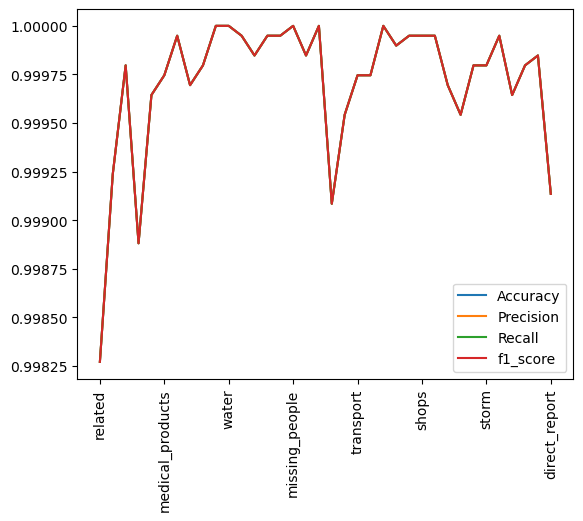

In [103]:
train_score_df.plot(rot=90)

In [104]:
test_score_df = get_score_df(y_test, y_test_pred)
test_score_df

,Accuracy,Precision,Recall,f1_score
related,0.809277,0.809277,0.809277,0.809277
request,0.897009,0.897009,0.897009,0.897009
offer,0.994965,0.994965,0.994965,0.994965
aid_related,0.779829,0.779829,0.779829,0.779829
medical_help,0.922338,0.922338,0.922338,0.922338
medical_products,0.949954,0.949954,0.949954,0.949954
search_and_rescue,0.975893,0.975893,0.975893,0.975893
security,0.981996,0.981996,0.981996,0.981996
military,0.970247,0.970247,0.970247,0.970247
child_alone,1.000000,1.000000,1.000000,1.000000


<Axes: >

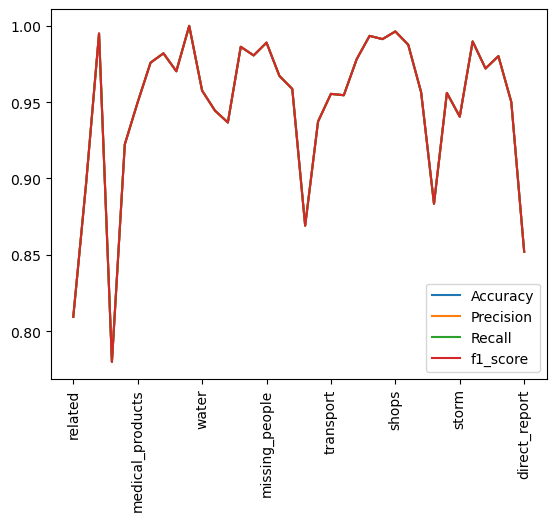

In [105]:
test_score_df.plot(rot=90)

It seems pretty normal, precision and recall are very close for both the training set and test set, and test set scores lower than trianng set

### 6. Improve your model
Use grid search to find better parameters. 

In [92]:
# find list of parameters to tune from pipeline
pipeline.get_params()

{'memory': None,
 'steps': [('vert',
   CountVectorizer(tokenizer=<function tokenize at 0x7f579248f640>)),
  ('tfidf', TfidfTransformer()),
  ('clf', MultiOutputClassifier(estimator=RandomForestClassifier()))],
 'verbose': False,
 'vert': CountVectorizer(tokenizer=<function tokenize at 0x7f579248f640>),
 'tfidf': TfidfTransformer(),
 'clf': MultiOutputClassifier(estimator=RandomForestClassifier()),
 'vert__analyzer': 'word',
 'vert__binary': False,
 'vert__decode_error': 'strict',
 'vert__dtype': numpy.int64,
 'vert__encoding': 'utf-8',
 'vert__input': 'content',
 'vert__lowercase': True,
 'vert__max_df': 1.0,
 'vert__max_features': None,
 'vert__min_df': 1,
 'vert__ngram_range': (1, 1),
 'vert__preprocessor': None,
 'vert__stop_words': None,
 'vert__strip_accents': None,
 'vert__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vert__tokenizer': <function __main__.tokenize(text)>,
 'vert__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'tfidf_

In [115]:
# custom scoring matrics based on f1_score

def multi_f1(y_true, y_pred):
    '''
    input - true matrix, prediction matrix
    output - average f1_score 
    '''
    score_df = get_score_df(y_true, y_pred)
    return np.mean(score_df['f1_score'])

In [116]:
score = make_scorer(multi_f1)

In [123]:
parameters = {
      'clf__estimator__max_features': ['sqrt', None],
      'clf__estimator__max_depth': [5, 10]
}

cv = GridSearchCV(pipeline, param_grid = parameters, scoring=score, verbose=10)

In [124]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START clf__estimator__max_depth=5, clf__estimator__max_features=sqrt


/home/mlc/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5; 1/4] END clf__estimator__max_depth=5, clf__estimator__max_features=sqrt;, score=0.925 total time=  30.7s
[CV 2/5; 1/4] START clf__estimator__max_depth=5, clf__estimator__max_features=sqrt


/home/mlc/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5; 1/4] END clf__estimator__max_depth=5, clf__estimator__max_features=sqrt;, score=0.924 total time=  30.1s
[CV 3/5; 1/4] START clf__estimator__max_depth=5, clf__estimator__max_features=sqrt


/home/mlc/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5; 1/4] END clf__estimator__max_depth=5, clf__estimator__max_features=sqrt;, score=0.927 total time=  30.3s
[CV 4/5; 1/4] START clf__estimator__max_depth=5, clf__estimator__max_features=sqrt


/home/mlc/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5; 1/4] END clf__estimator__max_depth=5, clf__estimator__max_features=sqrt;, score=0.927 total time=  30.6s
[CV 5/5; 1/4] START clf__estimator__max_depth=5, clf__estimator__max_features=sqrt


/home/mlc/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5; 1/4] END clf__estimator__max_depth=5, clf__estimator__max_features=sqrt;, score=0.929 total time=  30.5s
[CV 1/5; 2/4] START clf__estimator__max_depth=5, clf__estimator__max_features=None


/home/mlc/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5; 2/4] END clf__estimator__max_depth=5, clf__estimator__max_features=None;, score=0.945 total time= 3.5min
[CV 2/5; 2/4] START clf__estimator__max_depth=5, clf__estimator__max_features=None


/home/mlc/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5; 2/4] END clf__estimator__max_depth=5, clf__estimator__max_features=None;, score=0.944 total time= 3.6min
[CV 3/5; 2/4] START clf__estimator__max_depth=5, clf__estimator__max_features=None


/home/mlc/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5; 2/4] END clf__estimator__max_depth=5, clf__estimator__max_features=None;, score=0.946 total time= 3.6min
[CV 4/5; 2/4] START clf__estimator__max_depth=5, clf__estimator__max_features=None


/home/mlc/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5; 2/4] END clf__estimator__max_depth=5, clf__estimator__max_features=None;, score=0.945 total time= 3.6min
[CV 5/5; 2/4] START clf__estimator__max_depth=5, clf__estimator__max_features=None


/home/mlc/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5; 2/4] END clf__estimator__max_depth=5, clf__estimator__max_features=None;, score=0.948 total time= 3.6min
[CV 1/5; 3/4] START clf__estimator__max_depth=10, clf__estimator__max_features=sqrt


/home/mlc/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5; 3/4] END clf__estimator__max_depth=10, clf__estimator__max_features=sqrt;, score=0.926 total time=  32.5s
[CV 2/5; 3/4] START clf__estimator__max_depth=10, clf__estimator__max_features=sqrt


/home/mlc/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5; 3/4] END clf__estimator__max_depth=10, clf__estimator__max_features=sqrt;, score=0.925 total time=  32.5s
[CV 3/5; 3/4] START clf__estimator__max_depth=10, clf__estimator__max_features=sqrt


/home/mlc/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5; 3/4] END clf__estimator__max_depth=10, clf__estimator__max_features=sqrt;, score=0.928 total time=  32.6s
[CV 4/5; 3/4] START clf__estimator__max_depth=10, clf__estimator__max_features=sqrt


/home/mlc/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5; 3/4] END clf__estimator__max_depth=10, clf__estimator__max_features=sqrt;, score=0.928 total time=  32.6s
[CV 5/5; 3/4] START clf__estimator__max_depth=10, clf__estimator__max_features=sqrt


/home/mlc/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5; 3/4] END clf__estimator__max_depth=10, clf__estimator__max_features=sqrt;, score=0.930 total time=  32.7s
[CV 1/5; 4/4] START clf__estimator__max_depth=10, clf__estimator__max_features=None


/home/mlc/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5; 4/4] END clf__estimator__max_depth=10, clf__estimator__max_features=None;, score=0.947 total time= 6.7min
[CV 2/5; 4/4] START clf__estimator__max_depth=10, clf__estimator__max_features=None


/home/mlc/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5; 4/4] END clf__estimator__max_depth=10, clf__estimator__max_features=None;, score=0.946 total time= 6.8min
[CV 3/5; 4/4] START clf__estimator__max_depth=10, clf__estimator__max_features=None


/home/mlc/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5; 4/4] END clf__estimator__max_depth=10, clf__estimator__max_features=None;, score=0.949 total time= 6.8min
[CV 4/5; 4/4] START clf__estimator__max_depth=10, clf__estimator__max_features=None


/home/mlc/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5; 4/4] END clf__estimator__max_depth=10, clf__estimator__max_features=None;, score=0.948 total time= 6.9min
[CV 5/5; 4/4] START clf__estimator__max_depth=10, clf__estimator__max_features=None


/home/mlc/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5; 4/4] END clf__estimator__max_depth=10, clf__estimator__max_features=None;, score=0.950 total time= 6.9min


/home/mlc/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('vert',
                                        CountVectorizer(tokenizer=<function tokenize at 0x7f579248f640>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier()))]),
             param_grid={'clf__estimator__max_depth': [5, 10],
                         'clf__estimator__max_features': ['sqrt', None]},
             scoring=make_scorer(multi_f1), verbose=10)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [126]:
y_train_pred_optimized = cv.predict(X_train)
y_test_pred_optimized = cv.predict(X_test)

In [127]:
#Comparint the optimized result with the previous model result
train_optimized_score_df = get_score_df(y_train, y_train_pred_optimized)
test_optimized_score_df = get_score_df(y_test, y_test_pred_optimized)


<Axes: >

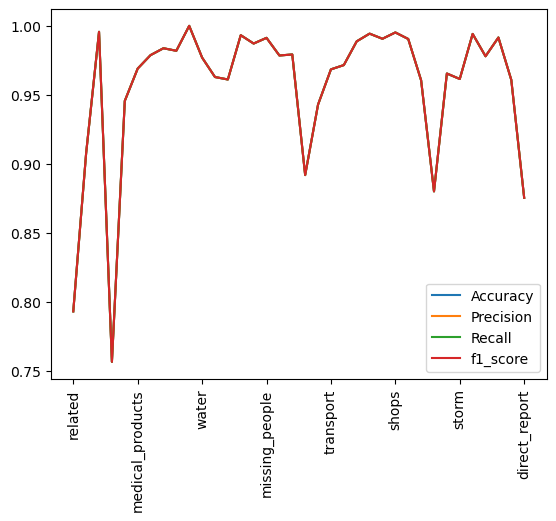

In [133]:
train_optimized_score_df.plot(rot=90)

<Axes: >

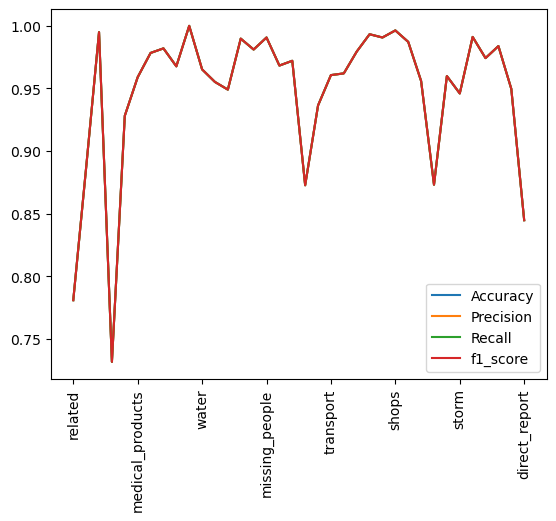

In [134]:
test_optimized_score_df.plot(rot=90)

In [137]:
#Comparing the origina RandomForest vs RandomForest with Grid SearchCV

original_train = train_score_df['f1_score'].mean()
original_test = test_score_df['f1_score'].mean()
optimized_train = train_optimized_score_df['f1_score'].mean()
optimized_test = test_optimized_score_df['f1_score'].mean()

print('Original train f1 {}, Original test f1 {}'.format(original_train, original_test))
print('Optimized train f1 {}, Optimized test f1 {}'.format(optimized_train, optimized_test))


Original train f1 0.9997117960193944, Original test f1 0.9484962533482523
Optimized train f1 0.9567976582013813, Optimized test f1 0.9482546705998036


**Comments**

- As seen from the optimization results, actually the grid search function has lower training f1, but the two models showed very close f1 scores on the test set.
- Since the default params of RandomForestClassifier doesn't restrict the max depth of the model, it's possible there are some over-fitting occuring on the default model, causing it to have higher trainig f1, but does not outperform test f1
- There is significant improvement on grid search params so I'll keep the default params model.
- Grid search is very time consuming. I have a high end cpu from last gen (zen 2), it still took over 60 mins to search to do 20 fits. Given that scikit-learn doesn't support gpu, it's unrealistic to keep expanding the grid.

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [158]:
# Try Adaboost classification algorithm
pipeline_ada = Pipeline([
    ('vert', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(AdaBoostClassifier()))
])

pipeline_ada.fit(X_train, y_train)

/home/mlc/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vert',
                 CountVectorizer(tokenizer=<function tokenize at 0x7f579248f640>)),
                ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(estimator=AdaBoostClassifier()))])

In [159]:
# Evaulating the score of AdaBoost Classifier test 

y_train_ada_pred = pipeline_ada.predict(X_train)
y_test_ada_pred = pipeline_ada.predict(X_test)
train_ada_score_df = get_score_df(y_train, y_train_ada_pred)
test_ada_score_df = get_score_df(y_test, y_test_ada_pred)

<Axes: >

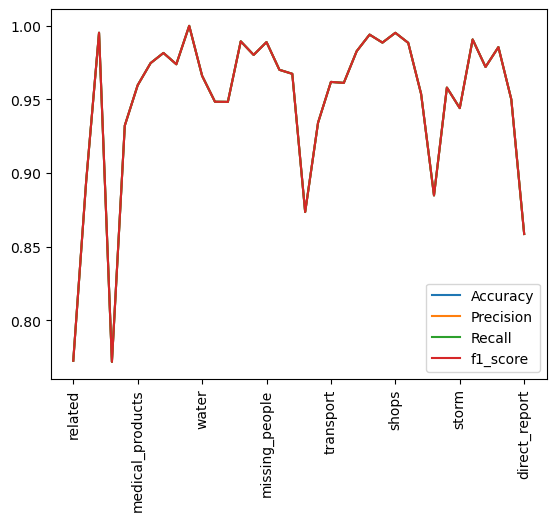

In [160]:
train_ada_score_df.plot(rot=90)

<Axes: >

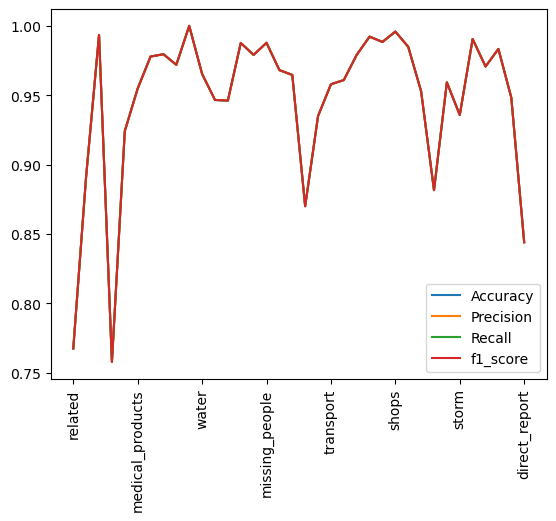

In [161]:
test_ada_score_df.plot(rot=90)

In [162]:
print('AdaBoost training f1 {}, Adaboost test f1 {}'.format(train_ada_score_df['f1_score'].mean(), test_ada_score_df['f1_score'].mean()))


AdaBoost training f1 0.9497931712609774, Adaboost test f1 0.9470806632082192


**Comments**

So the Adaboost performs similarly to RandomForestClassifier with default parameters with less overfitting
The Adaboost will be selected to save as file since the size is much smaller. RandomForset model generated a model file close to 1G, which is probably due to the large number of depth and leaves. 

### 9. Export your model as a pickle file

In [163]:
file_name = 'classifier.pkl'
with open (file_name, 'wb') as f:
    pickle.dump(pipeline_ada, f)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.